# 02 - EDA
___

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import time

from nltk.corpus import stopwords
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

pd.options.display.max_columns = 35

___

In [2]:
# read in our card files
df = pd.read_csv('../Data/cards_cleaned.csv')
df.head()

,name,layout,colors,color_identity,mana_cost,cmc,type_line,card_type,super_type,sub_type,oracle_text,oracle_text_token,legalities,rarity,power,toughness,loyalty,card_faces,activated_ability,triggered_ability,oracle_text_back,oracle_text_back_token,colors_back,power_back,toughness_back,loyalty_back,card_type_back,super_type_back,sub_type_back,mana_cost_back
0,Static Orb,normal,[],[],{3},3.0,Artifact,Artifact,NONE,NONE,"As long as Static Orb is untapped, players can...",as long as static orb is untapped players can'...,legacy vintage commander duel,rare,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,Sensory Deprivation,normal,['U'],['U'],{U},1.0,Enchantment — Aura,Enchantment,NONE,Aura,Enchant creature Enchanted creature gets -3/-0.,enchant creature enchanted creature gets -3/-0,pioneer modern legacy pauper vintage penny com...,common,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,Road of Return,normal,['G'],['G'],{G}{G},2.0,Sorcery,Sorcery,NONE,NONE,Choose one — • Return target permanent card fr...,choose one return target permanent card from y...,legacy vintage commander duel,rare,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,Storm Crow,normal,['U'],['U'],{1}{U},2.0,Creature — Bird,Creature,NONE,Bird,Flying (This creature can't be blocked except ...,flying this creature can't be blocked except b...,modern legacy pauper vintage penny commander duel,common,1,2,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Walking Sponge,normal,['U'],['U'],{1}{U},2.0,Creature — Sponge,Creature,NONE,Sponge,{T}: Target creature loses your choice of flyi...,{t} target creature loses your choice of flyin...,legacy vintage commander duel,uncommon,1,1,NONE,NONE,1.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [3]:
df.dtypes

name                       object
layout                     object
colors                     object
color_identity             object
mana_cost                  object
cmc                       float64
type_line                  object
card_type                  object
super_type                 object
sub_type                   object
oracle_text                object
oracle_text_token          object
legalities                 object
rarity                     object
power                      object
toughness                  object
loyalty                    object
card_faces                 object
activated_ability         float64
triggered_ability         float64
oracle_text_back           object
oracle_text_back_token     object
colors_back                object
power_back                 object
toughness_back             object
loyalty_back               object
card_type_back             object
super_type_back            object
sub_type_back              object
mana_cost_back

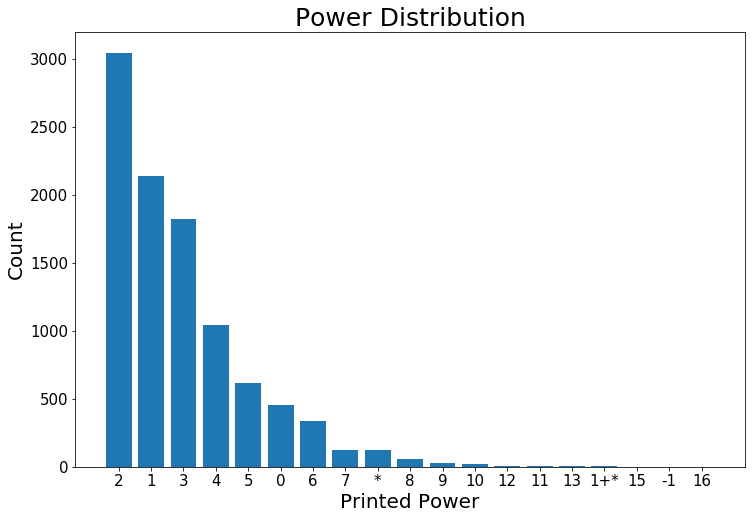

In [4]:
# get the power of the front and back half of each card
power = list(df.loc[df['power'] != 'NONE']['power'].values) + list(df.loc[df['power_back'] != 'NONE']['power_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(power)[0].value_counts().index, 
        height = pd.DataFrame(power)[0].value_counts(),
        )
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Power', fontsize=20)
plt.xticks(size=15)
plt.title(label='Power Distribution', fontsize=25);

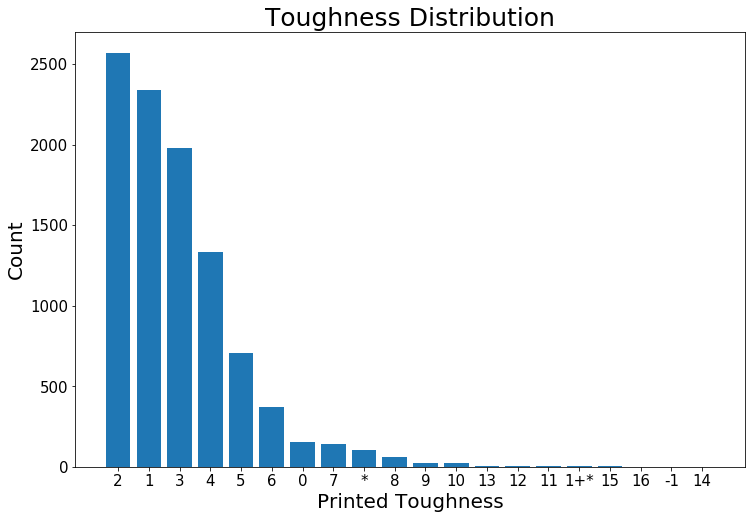

In [5]:
# get toughness from the front and back half of each card
toughness = list(df.loc[df['toughness'] != 'NONE']['toughness'].values) + list(df.loc[df['toughness_back'] != 'NONE']['toughness_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(toughness)[0].value_counts().index,
        height= pd.DataFrame(toughness)[0].value_counts())

plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Toughness', fontsize=20)
plt.xticks(size=15)
plt.title(label='Toughness Distribution', fontsize=25);

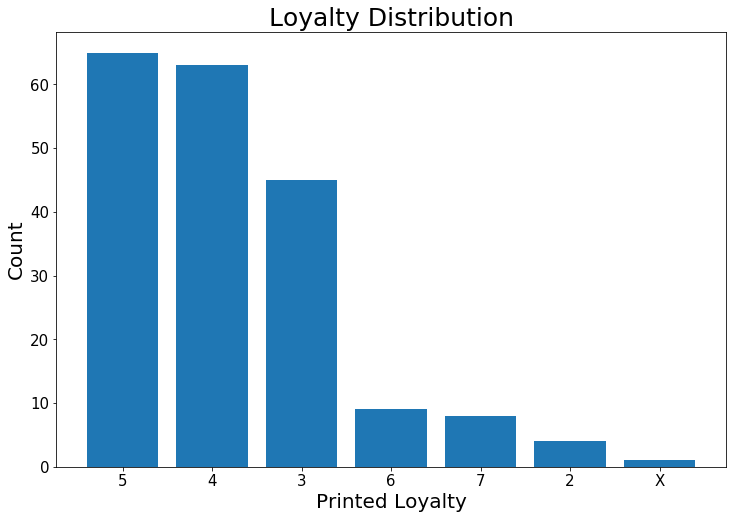

In [6]:
# get the loyalty from both front and back half of each card
loyalty = list(df.loc[df['loyalty'] != 'NONE']['loyalty'].values) + list(df.loc[df['loyalty_back'] != 'NONE']['loyalty_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(loyalty)[0].value_counts().index,
        height = pd.DataFrame(loyalty)[0].value_counts())
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Loyalty', fontsize=20)
plt.xticks(size=15)
plt.title(label='Loyalty Distribution', fontsize=25);

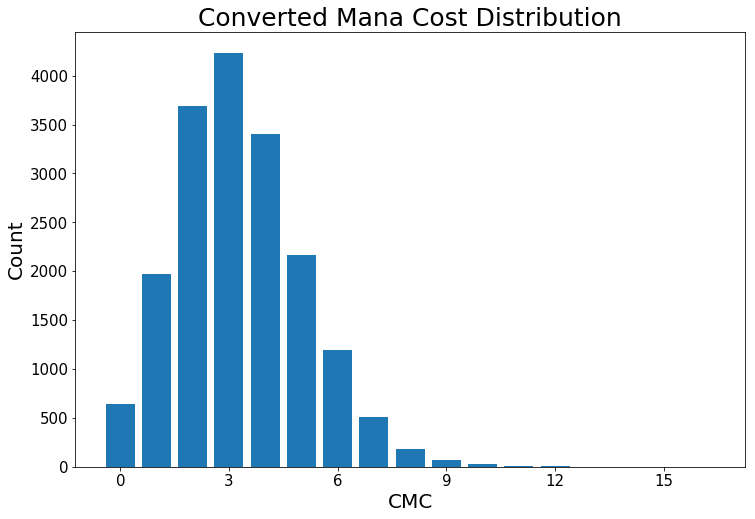

In [7]:
plt.figure(figsize=(12,8))
plt.bar(x = df['cmc'].value_counts().index, height=df['cmc'].value_counts());
plt.xticks(ticks=range(0,16,3));
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('CMC', fontsize=20)
plt.xticks(size=15)
plt.title(label='Converted Mana Cost Distribution', fontsize=25);

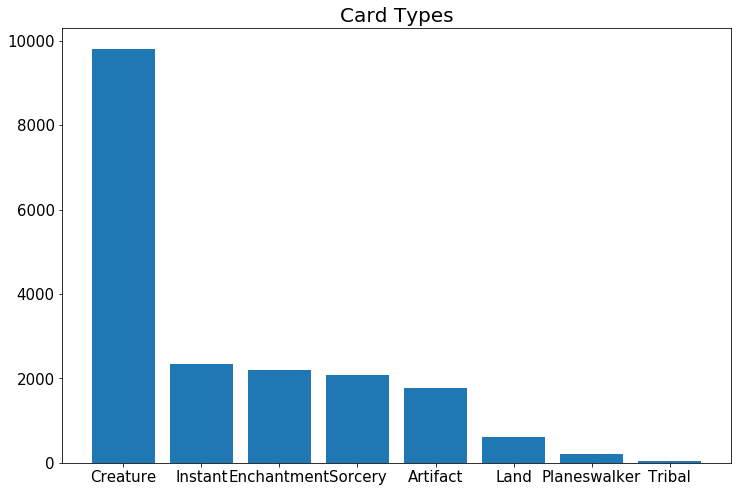

In [8]:
card_types = {
    'Creature' : 0,
    'Instant' : 0,
    'Enchantment' : 0,
    'Sorcery' : 0,
    'Artifact' : 0,
    'Land' : 0,
    'Planeswalker' : 0,
    'Tribal' : 0
}

# front half of cards
for card in df['card_type'].values:
    for ctype in card_types:
        if ctype in card:
            card_types[ctype] += 1
            
# back half of cards
for card in df.loc[df['card_type_back'] != 'NONE']['card_type_back'].values:
    for ctype in card_types:
        if ctype in card:
            card_types[ctype] += 1

plt.figure(figsize=(12,8))
plt.bar(x=list(card_types.keys()), height=list(card_types.values()))
plt.yticks(fontsize=15)
plt.title(label='Card Types', fontsize=20)
plt.xticks(fontsize=15);

___

## Count Vectorizer

In [9]:
X = df['oracle_text_token']

In [10]:
cvec = CountVectorizer(stop_words=['none'],
                      min_df=2,
                      max_df=.98,
                      ngram_range=(1,5),
                      token_pattern="[a-zA-Z{}+'0-9-/−]+")
X = cvec.fit_transform(X)

In [11]:
oracle_df = pd.DataFrame(X.toarray(), columns=cvec.get_feature_names())
oracle_df

,','{t},+0/+1,+0/+1 and,+0/+1 and has,+0/+1 counter,+0/+1 counter on,+0/+1 counters,+0/+1 counters on,+0/+1 for,+0/+1 for each,+0/+1 until,+0/+1 until end,+0/+1 until end of,+0/+1 until end of turn,+0/+1 whenever,+0/+1 whenever a,...,−8 target opponent gets,−8 target opponent gets an,−8 you,−8 you get,−8 you get an,−8 you get an emblem,−9,−9 gain,−9 gain control,−9 gain control of,−9 put,−9 you,−9 you get,−9 you get an,−9 you get an emblem,−x,−x chandra
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
oracle_df.sum().sort_values(ascending=False).head(60)

creature                  13295
the                       13155
you                       12884
a                         12295
of                        11588
your                       8041
target                     7759
to                         7491
this                       7210
card                       6583
it                         6541
turn                       5381
control                    5168
battlefield                5084
the battlefield            5077
or                         4455
that                       4443
and                        4291
if                         3896
damage                     3884
end                        3848
you control                3716
may                        3709
on                         3527
put                        3518
until                      3488
with                       3479
each                       3479
you may                    3422
player                     3421
enters                     3418
enters t

## Word2Vec

In [13]:
# Let's make a list of all the words in our oracle_text
text_list = [text for text in df.loc[df['oracle_text_token'] != 'NONE']['oracle_text_token']]
text_list += [text for text in df.loc[df['oracle_text_back_token'] != 'NONE']['oracle_text_back_token']]

all_oracle_text = ' '.join(text_list)

len(all_oracle_text)

2514518

In [14]:
import gensim.downloader as api

In [15]:
corpus = api.load('text8')

In [16]:
iter(corpus)

<generator object Dataset.__iter__ at 0x10eb10a98>

In [17]:
all_oracle_text.split()[:10]

['as',
 'long',
 'as',
 'static',
 'orb',
 'is',
 'untapped',
 'players',
 "can't",
 'untap']

In [18]:
print(next(iter(corpus))[:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


In [19]:
from gensim.models.word2vec import Word2Vec
Word2Vec()

In [20]:
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# # If you want to use gensim's data, import their downloader
# # and load it.
# import gensim.downloader as api
# corpus = api.load('text8')

# If you have your own iterable corpus of cleaned data, you can 
# read it in as corpus and pass that in.

# Train a model! 
model = Word2Vec([all_oracle_text.split()],      # Corpus of data.
                 size=300,    # How many dimensions do you want in your word vector?
                 window=5,    # How many "context words" do you want?
                 min_count=1, # Ignores words below this threshold.
                 sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
                 workers=4)   # Number of "worker threads" to use (parallelizes process).

In [21]:
# Do what you'd like to do with your dataa!
model.most_similar("target")

/Users/Creighton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('if', 0.999962329864502),
 ('you', 0.999962329864502),
 ('creature', 0.9999611377716064),
 ('when', 0.9999600052833557),
 ('to', 0.9999599456787109),
 ('whenever', 0.9999595880508423),
 ('flying', 0.9999594688415527),
 ('with', 0.9999590516090393),
 ('sacrifice', 0.9999589920043945),
 ('a', 0.9999589920043945)]

In [22]:
model['target']

/Users/Creighton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.37599882,  0.03985912, -0.30230755, -0.06946804,  0.01642459,
       -0.14876848,  0.37987092, -0.10518103,  0.00802607, -0.22104043,
       -0.06843857, -0.0823387 ,  0.11497424,  0.00304227, -0.06626457,
        0.3917928 ,  0.16500054,  0.17821568,  0.13597739, -0.06081595,
       -0.07515501,  0.16791156,  0.07535699, -0.01135073,  0.2829883 ,
       -0.28411674, -0.18233618,  0.02782819, -0.22671705,  0.0520382 ,
        0.30053055,  0.11297367,  0.2597508 ,  0.22322467,  0.01938744,
        0.35046542, -0.16464521, -0.00178594,  0.05848026, -0.17781731,
        0.1695476 ,  0.19304626,  0.07801791, -0.24236485,  0.01160984,
       -0.17686301,  0.35371307,  0.16481435, -0.24145773, -0.05809026,
        0.19972102, -0.17254938, -0.15147105,  0.04030998,  0.04940214,
        0.14408483, -0.02268716, -0.1031137 ,  0.11164292,  0.0786801 ,
        0.12341379,  0.22690818,  0.17585605, -0.03624054, -0.00804124,
       -0.05993764,  0.12087137,  0.11514105, -0.07783645,  0.09

In [23]:
model.vocabulary

In [24]:
# now let's get a list of the vectors for each word in our oracle text
word_vec = [model[word] for word in all_oracle_text.split()]

/Users/Creighton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [25]:
# now let's make a dataframe for our oracle text words and their corresponding vectors
w2vdf = pd.DataFrame.from_dict(dict(zip(all_oracle_text.split(), word_vec))).T
w2vdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
as,-0.429210,0.044330,-0.346113,-0.078909,0.017225,-0.171356,0.435106,-0.119622,0.006430,-0.253278,-0.081403,-0.093867,0.132278,0.005103,-0.079764,0.446060,0.192105,...,0.072839,-0.138655,-0.039079,-0.018314,-0.114549,0.160419,-0.092081,-0.013726,-0.049123,0.056002,-0.042297,-0.358579,0.181042,-0.393715,-0.061566,0.095746,-0.095692
long,-0.282525,0.029717,-0.229146,-0.049699,0.009160,-0.110386,0.285020,-0.079844,0.004173,-0.165853,-0.050774,-0.062026,0.087447,0.001820,-0.051539,0.296562,0.124567,...,0.046679,-0.091176,-0.023982,-0.012308,-0.073461,0.104634,-0.060507,-0.011647,-0.030774,0.036800,-0.027648,-0.235561,0.119419,-0.259504,-0.039781,0.060167,-0.062062
static,-0.008112,0.000988,-0.008337,-0.001824,0.000362,-0.002284,0.009263,-0.002481,-0.001272,-0.004860,-0.000522,-0.002387,0.004391,0.001116,-0.000072,0.009253,0.002925,...,0.000357,-0.003884,-0.000709,0.000147,-0.002464,0.003019,-0.003323,-0.001800,-0.002261,0.001681,-0.000554,-0.008382,0.003176,-0.008904,-0.002717,0.002613,-0.001377
orb,-0.011547,0.001219,-0.008613,-0.003184,-0.000042,-0.004472,0.009873,-0.001838,-0.001373,-0.006884,-0.002257,-0.002167,0.003327,-0.000065,-0.002096,0.010210,0.003905,...,0.001719,-0.002996,-0.000805,-0.001702,-0.001529,0.002982,-0.001116,-0.001389,-0.001639,0.000226,0.000517,-0.009178,0.005977,-0.009231,-0.002063,0.002666,-0.001349
is,-0.390193,0.041320,-0.315268,-0.072486,0.017170,-0.155127,0.394580,-0.108187,0.006619,-0.228239,-0.070059,-0.084252,0.116709,0.003098,-0.068550,0.404028,0.171437,...,0.064414,-0.126922,-0.034887,-0.013256,-0.100637,0.147378,-0.082510,-0.015505,-0.044884,0.049324,-0.039808,-0.322941,0.166067,-0.358718,-0.056652,0.084505,-0.087485


In [26]:
w2vdf.shape

(9769, 300)

In [27]:
t0 = time.time()

# Initialize t-SNE
tsne = TSNE(random_state = 42, perplexity = 200, n_iter=500)

tsne_df = tsne.fit_transform(w2vdf)

print((time.time() - t0)/60)

4.73147889773051


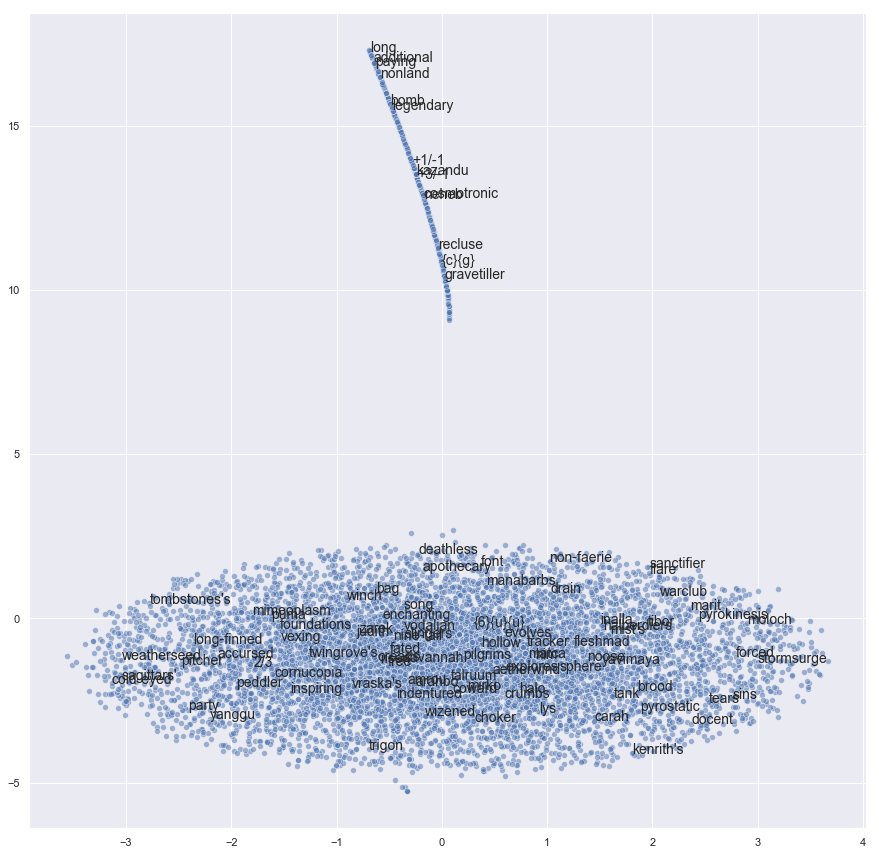

In [28]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (15, 15))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# initialize list of texts
texts = []
words_to_plot = list(np.arange(1, w2vdf.shape[0], 100))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], w2vdf.index[word], fontsize = 14))
    